<a href="https://colab.research.google.com/github/nunorfidalgo/AD2425_TP/blob/main/AD2425_TP_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup, Version check and Common imports


In [5]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers

import kagglehub
import pathlib
import pandas as pd

from warnings import filterwarnings
filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

print('Python version: ', sys.version_info)
print('TF version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

Python version:  sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
TF version:  2.18.0
Keras version:  3.8.0
GPU is available


# Data Fetching and Loading

In [2]:
# Download the Intel Image Classification dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


# List paths

In [17]:
seg_pred_path = (path + '/seg_pred/seg_pred/')
print("Path to seg_pred files:", seg_pred_path)

seg_test_path = (path + '/seg_test/seg_test/')
print("Path to seg_test files:", seg_test_path)

seg_train_path = (path + '/seg_train/seg_train/')
print("Path to seg_train files:", seg_train_path)

Path to seg_pred files: /kaggle/input/intel-image-classification/seg_pred/seg_pred/
Path to seg_test files: /kaggle/input/intel-image-classification/seg_test/seg_test/
Path to seg_train files: /kaggle/input/intel-image-classification/seg_train/seg_train/


# Count images of each directory

In [19]:
# Check the total number of images
seg_pred_dir = pathlib.Path(seg_pred_path)
seg_pred_img_count = len(list(seg_pred_dir.glob('*.jpg')))
print("Count pred images: ", seg_pred_img_count)

seg_test_dir = pathlib.Path(seg_test_path)
seg_test_img_count = len(list(seg_test_dir.glob('*/*.jpg')))
print("Count test images: ", seg_test_img_count)

seg_train_dir = pathlib.Path(seg_train_path)
seg_train_img_count = len(list(seg_train_dir.glob('*/*.jpg')))
print("Count train images: ", train_img_count)

Count pred images:  7301
Count test images:  3000
Count train images:  14034


# Creation of the dataset objects

 The images in the folders are not divided in train and validation datasets

 The following code divides samples into 80% training and 20% validation.

 No test set is created


In [27]:
batch_size = 32
IMG_SIZE = (150, 150)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    seg_train_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


# Dataset detailed information

In [21]:
print('Nr. of classes: ', len(class_names))
print('Classes: ', class_names)

# Cardinality
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())

Nr. of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Cardinalidade Treino:  351
Cardinalidade Validacão:  88


# Visualize a few examples

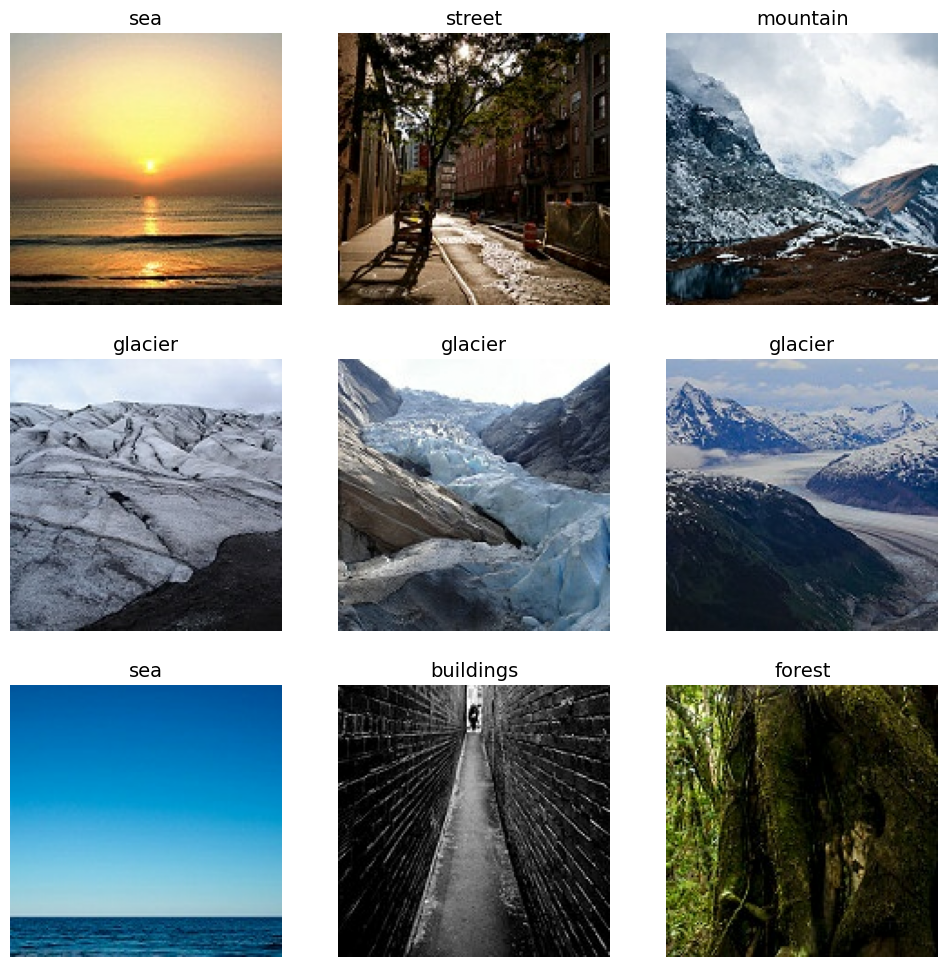

In [22]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255.)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Creation of a baseline



In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(150,150,3))

a = layers.Rescaling(scale = 1./255)(inputs)

a = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same') (a)
#a = layers.MaxPooling2D() (a)

a = layers.Conv2D(128, 3, activation='relu',padding='same') (a)
#a = layers.MaxPooling2D() (a)

a = layers.Conv2D(64, 3, activation='relu',padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(128, activation='relu') (a)
a = layers.Dense(64, activation='relu') (a)
a = layers.Dense(32, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model = keras.Model(inputs=inputs, outputs=outputs)

# Check the limit for the maximum number of parameters

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1440000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   184,320,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,706,662 (704.60 MB)

 Trainable params: 184,706,662 (704.60 MB)

 Non-trainable params: 0 (0.00 B)

# Model compilation

In [28]:
L = "sparse_categorical_crossentropy"

model.compile(loss=L, optimizer="adam", metrics=["accuracy"])

# Train for 20 epochs

In [26]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 192s 465ms/step - accuracy: 0.3987 - loss: 2.1799 - val_accuracy: 0.6304 - val_loss: 0.9642
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 301ms/step - accuracy: 0.6645 - loss: 0.8588 - val_accuracy: 0.6404 - val_loss: 0.9507
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 303ms/step - accuracy: 0.7862 - loss: 0.5610 - val_accuracy: 0.5969 - val_loss: 1.3883
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 303ms/step - accuracy: 0.8881 - loss: 0.3184 - val_accuracy: 0.5545 - val_loss: 2.0161
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 303ms/step - accuracy: 0.9296 - loss: 0.1979 - val_accuracy: 0.6098 - val_loss: 1.9624
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 303ms/step - accuracy: 0.9667 - loss: 0.1088 - val_accuracy: 0.6304 - val_loss: 1.9475
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 313ms/step - accuracy: 0.9822 - loss: 0.0733 - val_accuracy: 0.6290 - val_loss: 2.4677
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 302ms/step - accuracy: 0.9799 -

# Visualize results (both accuracy and loss)

<Axes: >

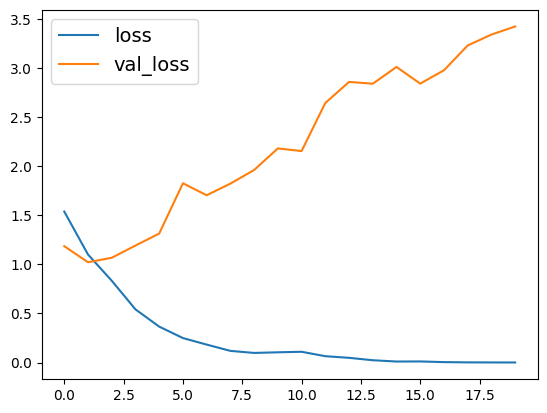

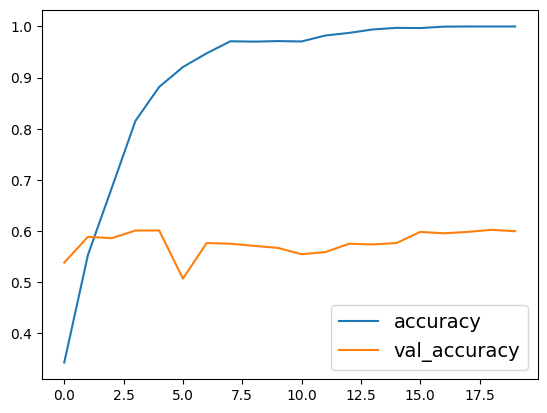

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()